In [1]:
import os
import torch
import torchvision
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset
import torch.optim as optim
import PIL
from PIL import Image
import torchvision.transforms as tt
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline
import time
from sklearn.model_selection import train_test_split
from torch.autograd import Variable
import pandas as pd
import seaborn
from facenet_pytorch import MTCNN
import mediapipe as mp
import cv2

In [5]:
train_transforms = tt.Compose([tt.Grayscale(num_output_channels=1), # Картинки чернобелые
                         
                         # Настройки для расширения датасета
                         tt.RandomHorizontalFlip(),           # Случайные повороты на 90 градусов
                         tt.RandomRotation(30),               # Случайные повороты на 30 градусов
                         #tt.Normalize((0.5), (0.5), inplace=True),
                         tt.Resize(64),
                         tt.RandomHorizontalFlip(),
                         tt.ToTensor()])                      # Приведение к тензору

test_transforms = tt.Compose([tt.Grayscale(num_output_channels=1), tt.Resize(64), tt.ToTensor()])

In [6]:
data_dir = './leapGestRecog/'

In [7]:
classes_train = os.listdir(data_dir + "/train")
classes_test = os.listdir(data_dir + "/test")
print(f'Train Classes - {classes_train}')
print(f'test Classes - {classes_test}')

Train Classes - ['down', 'fist', 'ok', 'palm', 'thumb']
test Classes - ['down', 'fist', 'ok', 'palm', 'thumb']


In [8]:
digit_to_classname = {0:'down', 1:'fist', 2:'ok', 3:'palm', 4:'thumb'}

In [9]:
train_dataset = ImageFolder(data_dir + '/train', train_transforms)
test_dataset  = ImageFolder(data_dir + '/test', test_transforms)

In [10]:
batch_size = 32

In [11]:
train_dataloader = DataLoader(train_dataset, batch_size, shuffle=True, num_workers=3, pin_memory=True)
test_dataloader = DataLoader(test_dataset, batch_size, num_workers=3, pin_memory=True)

In [40]:
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        print(images[0].shape)
        ax.imshow(make_grid(images[:64], nrow=8).permute(1, 2, 0))
        break

torch.Size([1, 64, 170])


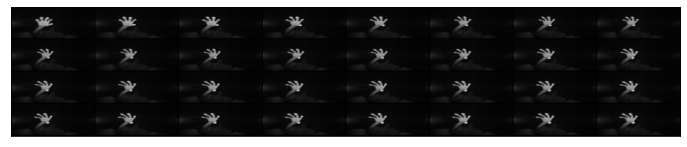

In [41]:
show_batch(test_dataloader)

In [12]:
def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        return len(self.dl)

In [14]:
device = get_default_device()
device

device(type='cpu')

In [15]:
train_dataloader = DeviceDataLoader(train_dataloader, device)
test_dataloader = DeviceDataLoader(test_dataloader, device)

In [16]:
class ResNet(nn.Module):
    def __init__(self, in_chnls, num_cls):
        super().__init__()
        
        self.conv1 = self.conv_block(in_chnls, 64, pool=True)           # 64x24x24 
        self.conv2 = self.conv_block(64, 128, pool=True)                # 128x12x12
        self.resnet1 = nn.Sequential(self.conv_block(128, 128), self.conv_block(128, 128))    # Resnet layer 1: includes 2 conv2d
        
        self.conv3 = self.conv_block(128, 256, pool=True)       # 256x6x6 
        self.conv4 = self.conv_block(256, 512, pool=True)       # 512x3x3
        self.resnet2 = nn.Sequential(self.conv_block(512, 512), self.conv_block(512, 512))    # Resnet layer 2: includes 2 conv2d
        
        self.classifier = nn.Sequential(nn.AdaptiveMaxPool2d(1),
                                        nn.Flatten(),
                                        nn.Linear(512, num_cls))    # num_cls
        
    @staticmethod
    def conv_block(in_chnl, out_chnl, pool=False, padding=1):
        layers = [
            nn.Conv2d(in_chnl, out_chnl, kernel_size=3, padding=padding),
            nn.BatchNorm2d(out_chnl),
            nn.ReLU(inplace=True)]
        if pool: layers.append(nn.MaxPool2d(2))
        return nn.Sequential(*layers)
        
    def forward(self, xb):
        
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.resnet1(out) + out
        
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.resnet2(out) + out
#         print(out.shape)
#         print('*' * 20)
        return self.classifier(out)

In [17]:
len(classes_train)

5

In [103]:
model = to_device(ResNet(1, len(classes_train)), device)

In [104]:
if torch.cuda.is_available(): 
    torch.cuda.empty_cache()


epochs = 20
max_lr = 0.0001
grad_clip = 0.1
weight_decay = 1e-4
optimizer = torch.optim.Adam(model.parameters(), max_lr)

In [105]:
total_steps = len(train_dataloader)
print(f'{epochs} epochs, {total_steps} total_steps per epoch')

20 epochs, 32 total_steps per epoch


In [106]:
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, 
                                                steps_per_epoch=len(train_dataloader))

In [107]:
epoch_losses = []
true_y = []
pred_y = []

sm=nn.Softmax(dim=0)

for epoch in range(epochs):
    
    time1 = time.time()
    running_loss = 0.0
    epoch_loss = []
    for batch_idx, (data, labels) in enumerate(train_dataloader):
        data, labels = data, labels      
        
        optimizer.zero_grad()
        
        outputs = model(data)
        
#         print('outputs', outputs[0])
#         print('labels', labels[0])
        _, preds = torch.max(outputs, 1)
        #print(preds)
        
        true_y.append(labels.to('cpu'))
        pred_y.append(outputs.to('cpu'))
        
        loss = F.cross_entropy(outputs, labels)
        loss.backward()
        optimizer.step()
        scheduler.step()
        
        running_loss += loss.item()
        epoch_loss.append(loss.item())
        if (batch_idx+1) % 10000 == 9999:
            print(f'Train Epoch: {epoch+1}, Loss: {running_loss/10000}')
            time2 = time.time()
            print(f'Spend time for 10000 images: {time2 - time1} sec')
            time1 = time.time()
            running_loss = 0.0
    print(f'Epoch {epoch+1}, loss: ', np.mean(epoch_loss))
    epoch_losses.append(epoch_loss)

Epoch 1, loss:  1.191887652501464
Epoch 2, loss:  0.2568286639871076
Epoch 3, loss:  0.051251137047074735
Epoch 4, loss:  0.017374690869473852
Epoch 5, loss:  0.008311387391586322
Epoch 6, loss:  0.004072226918651722
Epoch 7, loss:  0.003401159559871303
Epoch 8, loss:  0.004204156241030432
Epoch 9, loss:  0.010713583418691996
Epoch 10, loss:  0.002718755489695468
Epoch 11, loss:  0.0013225321290519787
Epoch 12, loss:  0.0013769420165772317
Epoch 13, loss:  0.00410740653751418
Epoch 14, loss:  0.0014222931649783277
Epoch 15, loss:  0.0024433543294435367
Epoch 16, loss:  0.001226747327564226
Epoch 17, loss:  0.0008636461388960015
Epoch 18, loss:  0.0007208356792034465
Epoch 19, loss:  0.0007411725682686665
Epoch 20, loss:  0.0009063909146789229


Text(0.5, 1.0, 'losses vs. No. of epochs')

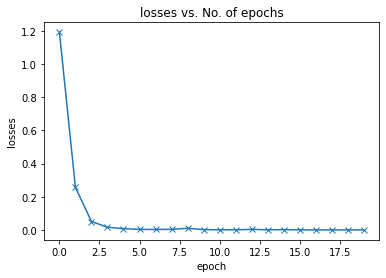

In [108]:
losses = [np.mean(loss) for loss in epoch_losses]
plt.plot(losses, '-x')
plt.xlabel('epoch')
plt.ylabel('losses')
plt.title('losses vs. No. of epochs')

In [116]:
PATH = "./models/gesture_detection_model_state_20_epochs.pth"

In [118]:
torch.save(model.state_dict(), PATH)

In [18]:
net=ResNet(1, len(classes_train)).to(device)
net.load_state_dict(torch.load('./models/gesture_detection_model_state_20_epochs.pth'))
net.eval()

ResNet(
  (conv1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (resnet1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=

torch.Size([32, 1, 64, 170])
torch.Size([5])


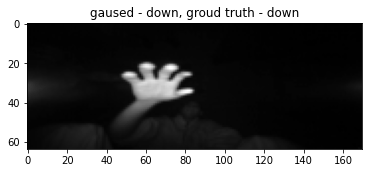

torch.Size([32, 1, 64, 170])
torch.Size([5])


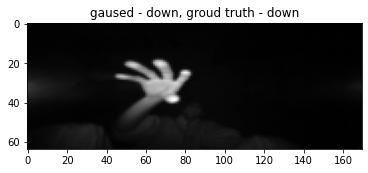

torch.Size([32, 1, 64, 170])
torch.Size([5])


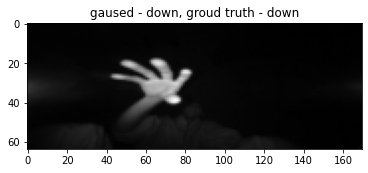

torch.Size([32, 1, 64, 170])
torch.Size([5])


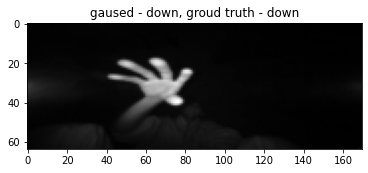

torch.Size([32, 1, 64, 170])
torch.Size([5])


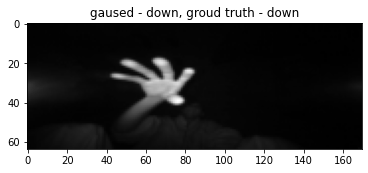

torch.Size([32, 1, 64, 170])
torch.Size([5])


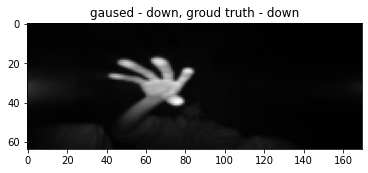

torch.Size([32, 1, 64, 170])
torch.Size([5])


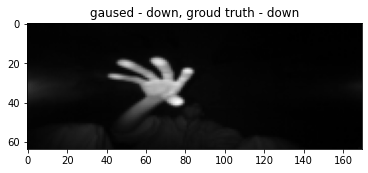

torch.Size([32, 1, 64, 170])
torch.Size([5])


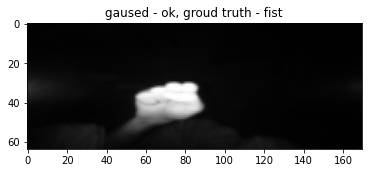

torch.Size([32, 1, 64, 170])
torch.Size([5])


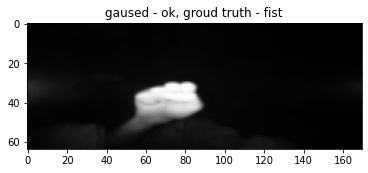

torch.Size([32, 1, 64, 170])
torch.Size([5])


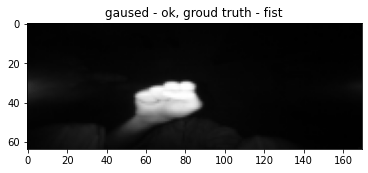

torch.Size([32, 1, 64, 170])
torch.Size([5])


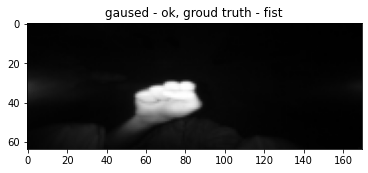

torch.Size([32, 1, 64, 170])
torch.Size([5])


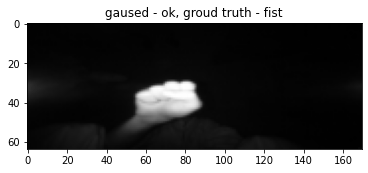

In [120]:
with torch.no_grad():
    for i, data in enumerate(test_dataloader):
        images, labels = data
        images, labels = images, labels
        outputs = net(images)
        print(images.shape)
        print(outputs[0].shape)
        plt.title(f'gaused - {digit_to_classname[outputs[0].argmax().item()]}, groud truth - {digit_to_classname[labels[0].data.item()]}')
        plt.imshow(images[0].cpu().squeeze(), cmap='gray')
        plt.show()
        if i>10:
            break

In [44]:
import numpy as np
from facenet_pytorch import MTCNN
from PIL import Image
import mediapipe as mp
import cv2
# mp_drawing = mp.solutions.drawing_utils
# mp_hands = mp.solutions.hands
 

# Класс детектирования и обработки лица с веб-камеры 
class FaceDetector(object):

    def __init__(self, mtcnn, mp, resnet,channels=1):
        # Создаем объект для считывания потока с веб-камеры(обычно вебкамера идет под номером 0. иногда 1)
        self.cap = cv2.cv2.VideoCapture(0) 
        self.mtcnn = mtcnn
        self.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
        self.emodel = resnet
        self.channels = channels
        self.mp = mp

    # Функция рисования найденных параметров на кадре
    def _draw(self, frame, boxes, probs, landmarks):
        try:
            for box, prob, ld in zip(boxes, probs, landmarks):
                # Рисуем обрамляющий прямоугольник лица на кадре
                cv2.rectangle(frame,
                              (int(box[0]), int(box[1])),
                              (int(box[2]), int(box[3])),
                              (0, 0, 255),
                              thickness=2)
                

                # пишем на кадре какая эмоция распознана
#                 cv2.putText(frame, 
#                     emotion, (int(box[2]), int(box[3])), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2, cv2.LINE_AA)

                # Рисуем особенные точки
#                 cv2.circle(frame, (int(ld[0][0]),int(ld[0][1])), 5, (0, 0, 255), -1)
#                 cv2.circle(frame, (int(ld[1][0]),int(ld[1][1])), 5, (0, 0, 255), -1)
#                 cv2.circle(frame, (int(ld[2][0]),int(ld[2][1])), 5, (0, 0, 255), -1)
#                 cv2.circle(frame, (int(ld[3][0]),int(ld[3][1])), 5, (0, 0, 255), -1)
#                 cv2.circle(frame, (int(ld[4][0]),int(ld[4][1])), 5, (0, 0, 255), -1)
        except Exception as e:
            print('Something wrong im draw function!')
            print(f'error : {e}')

        return frame
    
    # Функция для вырезания лиц с кадра
    @staticmethod
    def crop_faces(frame, boxes):
        faces = []
        for i, box in enumerate(boxes):
            faces.append(frame[int(box[1]-40):int(box[3]+40), 
                int(box[0]-40):int(box[2]+40)])
#             print(box)
        return faces
    
    @staticmethod
    def crop_hands(frame, hand_boxes):
        hands = []
        for i, hand_box in enumerate(hand_boxes):
            hands.append(frame[int(hand_box[1]-60):int(hand_box[3]+60), 
                int(hand_box[0]-60):int(hand_box[2]+60)])
        return hands
    #{0:'down', 1:'fist', 2:'ok', 3:'palm', 4:'thumb'}
    @staticmethod
    def digit_to_classname(digit):
        if digit == 0:
            return 'down'
        elif digit == 1:
            return 'fist'
        elif digit == 2:
            return 'ok'
        elif digit == 3:
            return 'palm'
        elif digit == 4:
            return 'thumb'
        
    @staticmethod
    def remove_background(frame):
        bgModel = cv2.createBackgroundSubtractorMOG2(0, 50)
        fgmask = bgModel.apply(frame, learningRate=0)
        kernel = np.ones((3, 3), np.uint8)
        fgmask = cv2.erode(fgmask, kernel, iterations=1)
        res = cv2.bitwise_and(frame, frame, mask=fgmask)
        return res  
    
    # Функция в которой будет происходить процесс считывания и обработки каждого кадра
    def run(self):

        blurValue = 5  # GaussianBlur parameter

        
        mp_drawing = self.mp.solutions.drawing_utils
        mp_hands = self.mp.solutions.hands
        with mp_hands.Hands(
    min_detection_confidence=0.5,
    min_tracking_confidence=0.5) as hands:
        # Заходим в бесконечный цикл
            while True:
                # Считываем каждый новый кадр - frame
                # ret - логическая переменая. Смысл - считали ли мы кадр с потока или нет
                ret, frame = self.cap.read()
                h, w, c = frame.shape
                try:
                    # детектируем расположение лица на кадре, вероятности на сколько это лицо
                    # и особенные точки лица
                    boxes, probs, landmarks = self.mtcnn.detect(frame, landmarks=True)



    #                 # Вырезаем лицо из кадра
                    face = self.crop_faces(frame, boxes)[0]

                    # Рисуем на кадре
                    self._draw(frame, boxes, probs, landmarks)

#                     img = self.remove_background(frame)
                    frame = cv2.cvtColor(cv2.flip(frame, 1), cv2.COLOR_BGR2RGB)
                    # To improve performance, optionally mark the image as not writeable to
                    # pass by reference.
                    frame.flags.writeable = False
                    results = hands.process(frame)

                    # Draw the hand annotations on the image.
                    frame.flags.writeable = True
                    frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)
                    hand_landmarks = results.multi_hand_landmarks
                    if hand_landmarks:
                        hand_boxes = []
                        for handLMs in hand_landmarks:
#                             hand_box = []
                            x_max = 0
                            y_max = 0
                            x_min = w
                            y_min = h
                            
                            for lm in handLMs.landmark:
#                                 
                                x, y = int(lm.x * w), int(lm.y * h)
                                if x > x_max:
                                    x_max = x
                                if x < x_min:
                                    x_min = x
                                if y > y_max:
                                    y_max = y
                                if y < y_min:
                                    y_min = y
#                             hand_box.append(x_min, y_min, x_max, y_max)
#                             hand_boxes.append(hand_box)
#                         print(handLMs)
#                         hand_cv = cv2.rectangle(frame, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)
                        hand_box = [x_min, y_min, x_max, y_max]
                        hand_boxes.append(hand_box)

#                         mp_drawing.draw_landmarks(frame, handLMs, mp_hands.HAND_CONNECTIONS)
                        # Вырезаем руку с кадра
                        hand = self.crop_hands(frame, hand_boxes)[0]
                        
                        # Меняем размер изображения лица для входа в нейронную сеть
                        hand_img = cv2.resize(hand,(71,64))
                        
                        hand = cv2.cvtColor(hand_img, cv2.COLOR_BGR2RGB)
                        # Превращаем в 1-канальное серое изображение
                        hand = cv2.cvtColor(hand, cv2.COLOR_BGR2GRAY)
                        hand = cv2.GaussianBlur(hand, (blurValue, blurValue), 0)
                        # Превращаем в 1-канальное черно-белое изображение
                        (thresh, hand) = cv2.threshold(hand, 60, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
                        cv2.imshow('bwhand', hand)

                        # Далее мы подготавливаем наш кадр для считывания нс
                        # Для этого перегоним его в формат pil_image
                        hand = Image.fromarray(hand)
                        #face = face.resize((48,48))
                        hand = np.asarray(hand).astype('float')
                        hand = torch.as_tensor(hand)


                        # Превращаем numpy-картинку вырезанного лица в pytorch-тензор
                        torch_hand = hand.unsqueeze(0).to(self.device).float()
                        # Загужаем наш тензор лица в нейронную сеть и получаем предсказание
                        emotion = self.emodel(torch_hand[None, ...])
                        print(emotion[0])
                        # Интерпретируем предсказание как строку нашей эмоции
                        emotion[0][3] = emotion[0][3]/1000
                        emotion = self.digit_to_classname(emotion[0].argmax().item())
                        hand_cv = cv2.rectangle(frame, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)
                        cv2.putText(frame, emotion,
                             (x_max, y_max), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2, cv2.LINE_AA)

    

                        
                except Exception as e:
                    print('Something wrong im main cycle!')
                    print(f'error : {e}')

                # Показываем кадр в окне, и назвываем его(окно) - 'Face Detection'
                cv2.imshow('Hands Detection', frame)


                # Функция, которая проверяет нажатие на клавишу 'q'
                # Если нажатие произошло - выход из цикла. Конец работы приложения
                if cv2.waitKey(1) & 0xFF == ord('q'):
                    break

            # Очищаем все объекты opencv, что мы создали
        self.cap.release()
        cv2.destroyAllWindows()

In [ ]:
mtcnn = MTCNN()
device = torch
model = ResNet(1,5)
model.load_state_dict(torch.load('./models/gesture_detection_model_state_20_epochs.pth'))

# ourResNet = FERModel(1, 7).to(device)
# ourResNet.load_state_dict(torch.load('./models/model2_50_epochs.pth'))


model.eval()
# Создаем объект нашего класса приложения
fcd = FaceDetector(mtcnn, mp, model)
# Запускаем
fcd.run()

# Я запускал в интерпретаторе
## Файл для запуска app.py